<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Assignment_07/Assignmesnt_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workspace Initialization

## Libraries & Standard Setup

In [1]:
!pip install jupyterthemes

In [0]:
!pip install -U -q PyDrive

In [0]:
%matplotlib inline

import os
import io

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# jt themes
from jupyterthemes import jtplot

# Display Images
from PIL import Image, ImageFilter

# IPython display
from IPython.display import display

# Loading Zip Files
import zipfile

# Working with images
import cv2

# Progress Bar (for long processes)
from tqdm import tqdm

In [0]:
import tensorflow as tf
import time

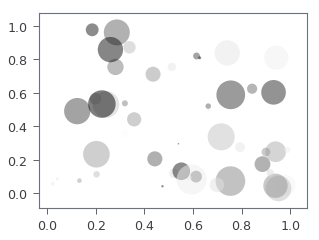

In [5]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

## Globals

In [0]:
RANDOM_SEED = 42

IMG_WIDTH = 50
IMG_HEIGHT = 50
IMG_CHANNELS = 1

IMG_SHAPE = [IMG_WIDTH, IMG_HEIGHT]
IMG_LENGTH = IMG_WIDTH * IMG_HEIGHT

Function to make output stable across runs.

In [0]:
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Project Dataset

## Cats Vs. Dogs Training Data

Load the cats vs. dogs dataset from mounted drive.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def label_img(img_name):
  if 'cat' in img_name: return 0.
  elif 'dog' in img_name: return 1.

In [10]:
training_data = []

with zipfile.ZipFile('/content/drive/My Drive/datasets/cats_vs_dogs/train.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      training_data.append([ np.array(img), np.array(label)])

100%|██████████| 25001/25001 [00:29<00:00, 835.87it/s]


## Data Set Exploration

In [11]:
training_data[0]

[array([[172, 180, 186, ..., 220, 213, 207],
        [172, 179, 187, ..., 221, 216, 210],
        [171, 179, 181, ..., 219, 217, 215],
        ...,
        [134, 137, 140, ...,   5,   5,   5],
        [129, 134, 136, ...,   3,   3,   3],
        [126, 131, 134, ...,   2,   2,   2]], dtype=uint8), array(0.)]

### Graphical Utility

Peek an image and it's label from the training data.

In [0]:
def peek_img( index, data = training_data):
  img_type = 'Unknown'
  
  if data[index][1] == 0.: img_type = 'Cat'
  elif data[index][1] == 1.: img_type = 'Dog'
  
  imshow(data[index][0], cmap = 'gray', interpolation = 'bicubic')
  plt.title(img_type)
  plt.show()

Show an image in grey scale format.

### Raw Image Data

Let's explore some of the training data. We'll start with the first image in the set in its raw form.

In [13]:
training_data[0][0]

array([[172, 180, 186, ..., 220, 213, 207],
       [172, 179, 187, ..., 221, 216, 210],
       [171, 179, 181, ..., 219, 217, 215],
       ...,
       [134, 137, 140, ...,   5,   5,   5],
       [129, 134, 136, ...,   3,   3,   3],
       [126, 131, 134, ...,   2,   2,   2]], dtype=uint8)

### Graphical Version

Now, let's view the actual image.

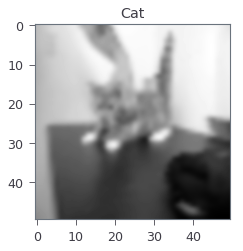

In [14]:
peek_img(0)

### Label verification

Now let's find a dog and make sure it's labeled correctly. Let's find the first 'dog' label.

In [15]:
dog_index = -1

for i, x in enumerate(training_data):
  if np.array_equal(x[1], 1.):
    dog_index = i
    break

dog_index

12500

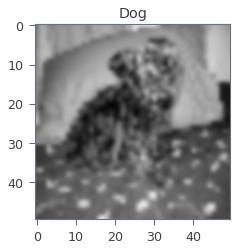

In [16]:
peek_img(dog_index)

Let's get some random images from the set and display their image & training label.

In [0]:
def plot_images(images, cls_true, indexes = None, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=1.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis, and the image index on the y-axis.
        ax.set_xlabel(xlabel)
        
        if indexes != None:
          ax.set_ylabel(indexes[i])
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
def plot_indexes(indexes):
  subset = [training_data[i] for i in indexes]

  images = []
  labels = []

  for i in subset:
    x, y = i

    images.append(x)

    if y == 0: labels.append('Cat')
    elif y == 1: labels.append('Dog')

  plot_images(images, labels, indexes)

Get some random indices.

In [0]:
import random

indexes = []

for x in range(9):
  indexes.append(random.randint(0, len(training_data)))

Show some random images from the training data.

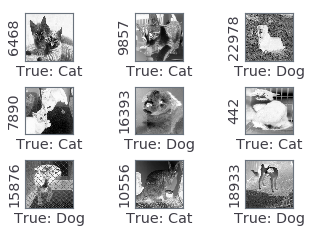

In [20]:
plot_indexes(indexes)

Shuffel the training data.

In [0]:
from random import shuffle 

shuffle(training_data)

Replot the same indexes to ensure shuffeling occured.

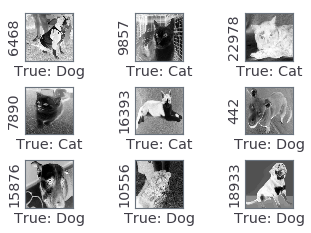

In [22]:
plot_indexes(indexes)

## Split Train & Test

In [0]:
train = training_data[:-500]
test = training_data[-500:]

Training data.

In [24]:
X_train = np.array([i[0] for i in train])
y_train = np.array([i[1] for i in train])
print(X_train.shape)
print(y_train.shape)

(24500, 50, 50)
(24500,)


Testing data.

In [0]:
X_test = np.array([i[0] for i in test])
y_test = np.array([i[1] for i in test])

# Deep Classification Model

Reset model to default state.

In [0]:
reset_graph()

## Model Input

In [27]:
n_inputs = IMG_WIDTH * IMG_HEIGHT * IMG_CHANNELS
n_inputs

2500

Each input is a 100x100x1 array, for a toal of 10,000 data points.

In [28]:
n_inputs

2500

## Model Output

Total outputs for a binary classifier is 2, cat or dog.

In [0]:
n_outputs = 2

TensorFlow variables.

## Model Variables

### Layering Variables

Convolutional Layer 1

In [0]:
filter_size1 = 5          # Convolution filters (kernel) are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters. 

Convolutional Layer 2

In [0]:
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 32 of these filters.

In [0]:
fc_size = 128

### Modeling Utilities

In [0]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [0]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [0]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    #layer_dp=tf.nn.dropout(layer, pkeep)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [0]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [0]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [0]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


In [0]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


In [0]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Execution

In [42]:
X_train.shape

(24500, 50, 50)

In [43]:
X_test.shape

(500, 50, 50)

#### TensorFlow Variables

In [44]:
x = tf.placeholder(tf.float32, shape=[None, IMG_LENGTH], name='x')
x

<tf.Tensor 'x:0' shape=(?, 2500) dtype=float32>

In [45]:
x_image = tf.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS])
x_image

<tf.Tensor 'Placeholder:0' shape=(?, 50, 50, 1) dtype=float32>

In [46]:
y_true = tf.placeholder(tf.float32, shape=[None, n_outputs], name='y_true')
y_true

<tf.Tensor 'y_true:0' shape=(?, 2) dtype=float32>

In [47]:
y_true_cls = tf.argmax(y_true, axis=1)
y_true_cls

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

#### Neural Network Configuration

In [48]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                   num_input_channels=IMG_CHANNELS,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

display('conv1: {}'.format(layer_conv1.shape))

layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

display('conv2: {}'.format(layer_conv2.shape))

layer_flat, num_features = flatten_layer(layer_conv2)

display('layer_flat: {}'.format(layer_flat.shape))

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

display('fc1: {}'.format(layer_fc1.shape))


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=n_outputs,
                         use_relu=False)

display('fc2'.format(layer_fc2.shape))

y_pred = tf.nn.softmax(layer_fc2)

display('pred'.format(y_pred.shape))

'conv1: (?, 25, 25, 16)'

'conv2: (?, 13, 13, 32)'

'layer_flat: (?, 5408)'

'fc1: (?, 128)'

'fc2'

'pred'

In [49]:
y_pred_cls = tf.argmax(y_pred, axis=1)
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [50]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cross_entropy

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



<tf.Tensor 'softmax_cross_entropy_with_logits_sg/Reshape_2:0' shape=(?,) dtype=float32>

In [51]:
cost = tf.reduce_mean(cross_entropy)
cost

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()

session.run(tf.global_variables_initializer())

train_batch_size = 64

**Please help here, I am stuck**

In [53]:
i, j = 0, 500
test_batch_size = 256

cls_pred = np.zeros(shape=num_test, dtype=np.int)

# The ending index for the next batch is denoted j.
j = min(i + test_batch_size, num_test)

# Get the images from the test-set between index i and j.
images = X_test[i:j, :]
images = images.reshape( -1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
images.shape

NameError: ignored

In [0]:
X_test.shape

In [0]:
i, j = 0, 500
test_batch_size = 256

cls_pred = np.zeros(shape=num_test, dtype=np.int)

# The ending index for the next batch is denoted j.
j = min(i + test_batch_size, num_test)

# Get the images from the test-set between index i and j.
images = X_test[i:j, :]

# Get the associated labels.
labels = y_test[i:j]

# Create a feed-dict with these images and labels.
feed_dict = {x: images,
            y_true: labels}

# Calculate the predicted class using TensorFlow.
cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

In [0]:
num_test

In [0]:
# Number of images in the test-set.
num_test = len(X_test)

# Allocate an array for the predicted classes which
# will be calculated in batches and filled into this array.
cls_pred = np.zeros(shape=num_test, dtype=np.int)

# Now calculate the predicted classes for the batches.
# We will just iterate through all the batches.
# There might be a more clever and Pythonic way of doing this.

# The starting index for the next batch is denoted i.
i = 0

while i < num_test:
    # The ending index for the next batch is denoted j.
    j = min(i + test_batch_size, num_test)

    # Get the images from the test-set between index i and j.
    images = X_test[i:j, :]

    # Get the associated labels.
    labels = y_test[i:j]

    # Create a feed-dict with these images and labels.
    feed_dict = {x: images,
                 y_true: labels}
    print
    # Calculate the predicted class using TensorFlow.
    cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

    # Set the start-index for the next batch to the
    # end-index of the current batch.
    i = j
    
# Convenience variable for the true class-numbers of the test-set.
cls_true = data.test.cls

# Create a boolean array whether each image is correctly classified.
correct = (cls_true == cls_pred)

# Calculate the number of correctly classified images.
# When summing a boolean array, False means 0 and True means 1.
correct_sum = correct.sum()

# Classification accuracy is the number of correctly classified
# images divided by the total number of images in the test-set.
acc = float(correct_sum) / num_test

# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, num_test))

# Summary